In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''
import random

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from omegaconf import OmegaConf

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

In [2]:
from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.utils import instantiate

In [3]:
with initialize(config_path="../training/conf/"):
    cfg = compose(config_name="config", overrides=["+experiment=conv_transformer_paragraphs"])

/tmp/ipykernel_28911/2869629028.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../training/conf/"):


In [4]:
net = instantiate(cfg.network)

In [5]:
loss_fn = instantiate(cfg.criterion)
datamodule = instantiate(cfg.datamodule)

/home/aktersnurra/.cache/pypoetry/virtualenvs/text-recognizer-ejNaVa9M-py3.9/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/aktersnurra/.cache/pypoetry/virtualenvs/text-recognizer-ejNaVa9M-py3.9/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [6]:
import torch

In [7]:
from text_recognizer.models.transformer import LitTransformer

In [8]:
model = LitTransformer.load_from_checkpoint("/home/aktersnurra/projects/text-recognizer/training/logs/runs/2022-09-19/00-23-48/checkpoints/epoch=156.ckpt", network=net, mapping=datamodule.mapping, loss_fn=loss_fn, optimizer_config=cfg.optimizer)

/home/aktersnurra/.cache/pypoetry/virtualenvs/text-recognizer-ejNaVa9M-py3.9/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (CharacterErrorRate). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [9]:
datamodule = instantiate(cfg.datamodule)
datamodule.prepare_data()
datamodule.setup()

2022-09-25 17:55:10.349 | INFO     | text_recognizer.data.iam_paragraphs:setup:110 - Loading IAM paragraph regions and lines for None...
2022-09-25 17:55:24.611 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:16 - Loading transforms from config: transform/paragraphs.yaml
2022-09-25 17:55:24.627 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:16 - Loading transforms from config: target_transform/pad.yaml
2022-09-25 17:55:26.874 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:16 - Loading transforms from config: test_transform/paragraphs.yaml
2022-09-25 17:55:26.880 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:16 - Loading transforms from config: target_transform/pad.yaml
2022-09-25 17:55:26.884 | INFO     | text_recognizer.data.iam_synthetic_paragraphs:setup:83 - IAM Synthetic dataset steup for stage None...
2022-09-25 17:55:39.296 | DEBUG    | text_recognizer.data.transforms.load_tran

In [18]:
dataset = datamodule.data_test

In [19]:
def _plot(image, figsize=(12,12), title='', vmin=0, vmax=255):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)

def convert_y_label_to_string(y, mapping, padding_index=3):
    return ''.join([mapping[int(i)] for i in y if i != padding_index])

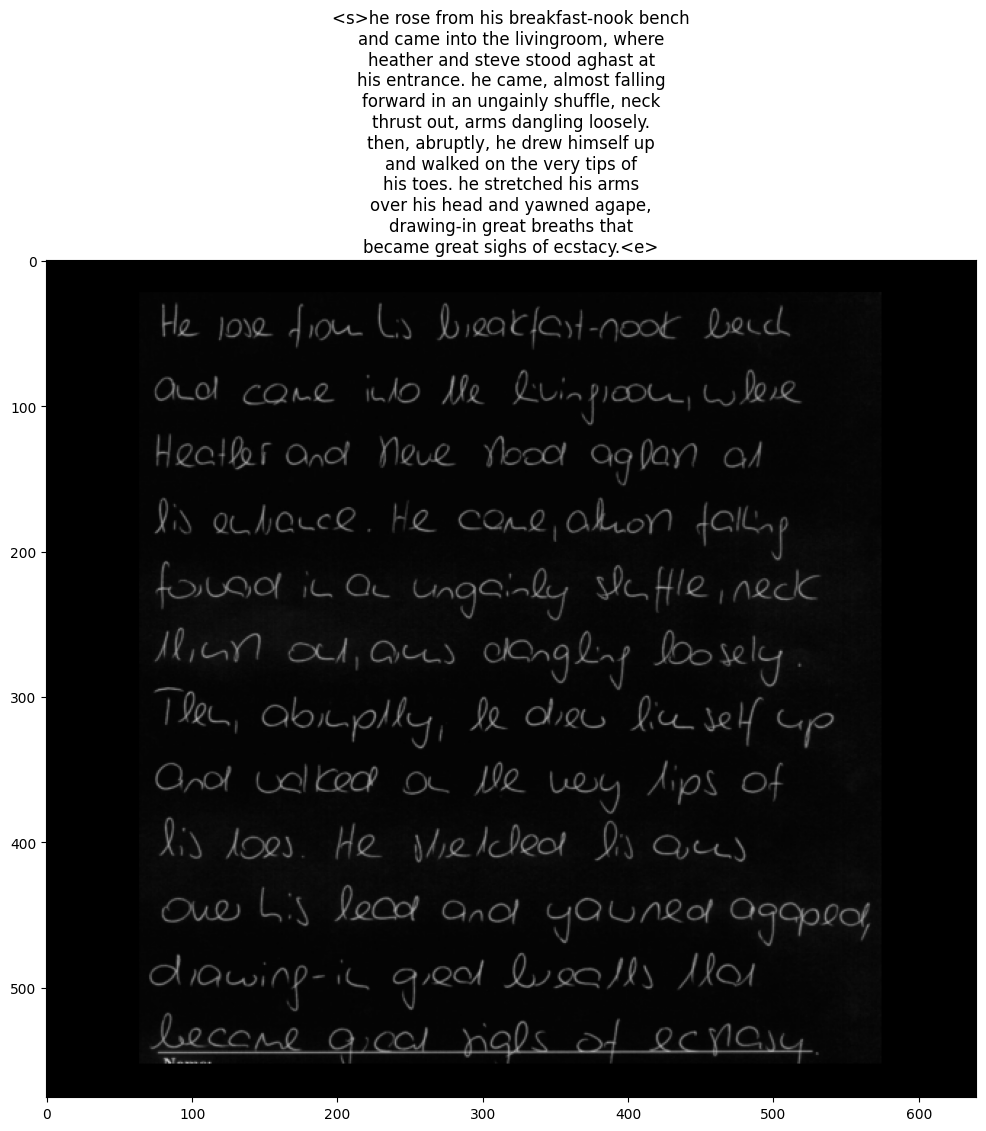

In [20]:
x, y = dataset[0]
_plot(x[0], vmax=1, title=convert_y_label_to_string(y, datamodule.mapping))

In [21]:
x.shape

torch.Size([1, 576, 640])

In [24]:
y_hat = model.predict(x.unsqueeze(0))

In [23]:
print(convert_y_label_to_string(y_hat[0], datamodule.mapping))

<s>the "nor (ib) 1), licatarth "moor(a) would #
sand con'rely (4) livingrou, 'after-in-law (b
theat cane, 'here room say day (104 and
fix on enouce. he conviyent falling porting
forward # out deliggacy detter neal
collib over achedoligap, loopely as exact
to behy abiliply, le die slick be c#
didn't lad be "le "le - very plies popul
to best loe: (he shell dea elief oycono mishni
one big beach and learly.
lobuis" is areal colonector actoralm character
had ciden<e>


In [5]:
from torchinfo import summary

In [6]:
summary(net, ((1, 1, 576, 640), (1, 682)), device="cpu", depth=4)

Layer (type:depth-idx)                                       Output Shape              Param #
ConvTransformer                                              [1, 58, 682]              --
├─ConvNext: 1-1                                              [1, 128, 18, 160]         4,209,408
│    └─Conv2d: 2-1                                           [1, 16, 576, 640]         800
│    └─ModuleList: 2                                         --                        --
│    │    └─ModuleList: 3                                    --                        --
│    │    │    └─ConvNextBlock: 4-1                          [1, 16, 576, 640]         10,080
│    │    │    └─Downsample: 4-2                             [1, 16, 288, 320]         1,040
│    │    └─ModuleList: 3                                    --                        --
│    │    │    └─ConvNextBlock: 4-3                          [1, 16, 288, 320]         10,080
│    │    │    └─Downsample: 4-4                             [1, 32, 144, 16